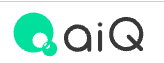

[disclaimer](../../disclaimer.txt/)

# aiQ Pos Consumer Goods/Elec/Retailer Evenly

In this sample notebook, we consider a composite portfolio with an equally-weighted allocation (one-third each) by combining factor returns for three POS alternative datasets. <br>
We confirm that the correlations between each factor return are low and that the composite portfolio exhibits high performance.

- aiQ POS Csmr Goods
- aiQ POS Elec Goods
- aiQ POS Retailer

In [1]:
# Commands to Automatically Update Custom Modules
%load_ext autoreload
%autoreload 2

## Step1: Import Library

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import plotly.io
from pathlib import Path
from aiq_strategy_robot.data.data_accessor import DAL

for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

if '../..' not in sys.path:
    sys.path.append('../..')

from libs.dataset import aiq_pos_csmr_goods as sc_goods
from libs.dataset import aiq_pos_elec_goods as sc_elec
from libs.dataset import aiq_pos_retailer as sc_retailer
from libs.dataset import common as sc_common
from libs.path import DEFAULT_DIR

- Create an instance of the standard data handler.
- The data handler is an object that holds libraries for data retrieval and data processing.

In [3]:
verbose = False
sdh = DAL()
sdh.transform.verbose = verbose

## Step2: Load Data to `sdh`
`sdh` is a data container object used within the analysis library all the notebooks utilize. <br>
Since the focus here is on a data analysis demo, we will load the data through a custom loader that has been prepared separately.

In [4]:
dat_id_retail = sc_retailer.register_retailer_data(sdh)
data_id_goods = sc_goods.register_csmr_goods_data(sdh)
data_id_elec = sc_elec.register_elec_goods_data(sdh)
data_id_mkt = sc_common.register_market(sdh, yf_switch=False, base_data_id=[dat_id_retail, data_id_goods, data_id_elec])

display(sdh.extract_definition)

category data_source   source    table           alias  \
data_id                                                          
1        RawData    external   sample  Unknown    pos_retailer   
2        RawData    external   sample  Unknown  pos_csmr_goods   
3        RawData    external   sample  Unknown  pos_elec_goods   
4        RawData    External  Unknown  Unknown  market_returns   

                                                   tickers  \
data_id                                                      
1        [1925, 2212, 2267, 2651, 2653, 2659, 2660, 266...   
2        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   
3        [1956, 2180, 2321, 2323, 2326, 2354, 2388, 246...   
4        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   

                      index       start_datetime         end_datetime  
data_id                                                                
1        [TICKER, DATETIME]  2010-04-30 00:00:00  2024-08-31 00:00:00  
2        [TICKER, DATETIME]  2008-03-16 00:00:00  2024-08-25 00:00:00  
3        [TICKER, DATETIME]  2009-01-01 00:00:00  2024-08-31 00:00:00  
4        [TICKER, DATETIME]  2004-09-27 00:00:00  2024-09-26 00:00:00

### Set labels to the loaded datasets in `sdh` for easier access later on.

In [5]:
sdh.set_alias(
    {dat_id_retail: 'retail', data_id_goods: 'goods', 
     data_id_elec: 'elec', data_id_mkt: 'mkt'})

> If you want to use your own financial data with the handler, please set the following flag to True. <br> Note that the sample financial data has already been adjusted for YoY.

In [6]:
USE_MY_MKT = False 

## Step 3: Verify the Factor Returns for Individual Datasets
Before combining, check the performance of each individual factor return.

In [7]:
# Load the objects used in Step 3.
from aiq_strategy_robot.evaluator import AltDataEvaluator, inv_return_stats, cumplot_return

In [8]:
# Create an instance of the main class used for data evaluation.
ade = AltDataEvaluator(sdh)

In [9]:
# please set USE_MY_MKT if you have prepared market data and set it to `sdh`.
# Otherwise, please set to False, which will allow you to work with the default derived data.
if USE_MY_MKT:
    # Convert market data from raw values to rate of change.
    bcktest_return_id = sdh.transform.log_diff(1, data_id=data_id_mkt, fields='close').variable_ids[0]
else:
    bcktest_return_id = sdh.transform.raw(data_id=data_id_mkt, fields='returns').variable_ids[0]

### Step3.1: POS CSMR Goods
- Here we check the performance of quantile portfolio using aiQ POS csmr goods dataset.
- Weekly rebalancing
- Data has at least a 4-business-day lag from the end of the week

In [10]:
n_shift = 6    # Considering the timing lag of data issuance
n_rolling = 12 # Calculate the 3-month moving average
n_diff = 52    # Calculate the year-over-year (YoY) comparison for the same week

In [11]:
signal_goods_id = (
    sdh.transform
    .mul('pos_sales', 'unit_price', data_id=data_id_goods)
    .resample('W', 'last')
    .sma(n_rolling)
    .log_diff(n_diff)
    .resample('D', 'last')
    .fillna(method='ffill', limit=7)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)

In [12]:
nq = 3
exe_cost = 0.0005

dfqret_goods, stats, dfsigqt = ade.q_backtest(
    signal_goods_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1           0.529754  0.034746  0.135763  0.255930  0.547989      8.484805   
#2           0.971958  0.063749  0.136368  0.467479  0.545186     12.243027   
#3           1.194613  0.078353  0.138225  0.566850  0.555496      8.815557   
#3-#1        0.664858  0.043607  0.047762  0.913012  0.529491     17.300362   
#3-#1(cost)  0.533008  0.034959  0.047747  0.732169  0.526273     17.300362   

               Max_DD  Calmar Ratio  
#1          -0.471190      0.073741  
#2          -0.402133      0.158528  
#3          -0.437458      0.179109  
#3-#1       -0.085672      0.508999  
#3-#1(cost) -0.093775      0.372800

### Step3.2: POS Retailer
- Here we check the performance of quantile portfolio using aiQ POS Retailer dataset.
- Monthly rebalancing
- Data has a lag of at least 5 trading days from the end of the month

In [13]:
n_shift = 7   # Consider the timing lag of data issuance
n_rolling = 2 # Calculate the 2-month moving average (since the data is monthly)
n_diff = 12   # Calculate the year-over-year comparison

In [14]:
signal_retailer_id = (
    sdh.transform
    .mul('pos_sales', 'share', data_id=dat_id_retail)
    .resample('M', 'last')
    .sma(n_rolling)
    .log_diff(n_diff)
    .resample('D', 'last')
    .fillna(method='ffill', limit=31)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)

In [15]:
nq = 3
exe_cost = 0.0005

dfqret_retailer, stats, dfsigqt = ade.q_backtest(
    signal_retailer_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1           0.500406  0.037722  0.138566  0.272229  0.532127      9.120986   
#2           1.215036  0.091592  0.143623  0.637727  0.538677     10.386671   
#3           1.630184  0.122887  0.145283  0.845842  0.548971      7.590602   
#3-#1        1.129778  0.085165  0.066589  1.278971  0.536806     16.711588   
#3-#1(cost)  1.018932  0.076809  0.066578  1.153678  0.534934     16.711588   

               Max_DD  Calmar Ratio  
#1          -0.603262      0.062529  
#2          -0.428510      0.213745  
#3          -0.409438      0.300135  
#3-#1       -0.125659      0.677746  
#3-#1(cost) -0.129892      0.591331

### Step3.3: POS Elec Goods
- Here we check the performance of quantile portfolio using aiQ POS Elec Goods dataset.
- Daily rebalancing
- Data has at least a 3-business-day lag

In [16]:
n_shift = 8    # Consider the data issuance timing lag
n_rolling = 14 # Calculate the 14-day moving average (data is daily)
n_diff = 252   # To calculate the year-over-year (YoY) change.
min_period = int(max(np.floor(n_rolling * 5 / 7), 1))

In [17]:
signal_elec_id = (
    sdh.transform
    .mul('pos_sales', 'unit_price', data_id=data_id_elec)
    .resample('D', 'last')
    .sma(n_rolling, min_period)
    .reindex(label=bcktest_return_id)
    .log_diff(n_diff)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)

In [18]:
nq = 3
exe_cost = 0.0005

dfqret_elec, stats, dfsigqt = ade.q_backtest(
    signal_elec_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1           0.086381  0.005912  0.204924  0.028850  0.530909     21.941417   
#2           0.979555  0.067043  0.203515  0.329423  0.535105     37.528834   
#3           1.325145  0.090695  0.204288  0.443958  0.546573     22.512822   
#3-#1        1.238764  0.084783  0.112606  0.752917  0.532587     44.454239   
#3-#1(cost)  0.914005  0.062556  0.112597  0.555574  0.527273     44.454239   

               Max_DD  Calmar Ratio  
#1          -0.788260      0.007500  
#2          -0.548355      0.122261  
#3          -0.484730      0.187105  
#3-#1       -0.244912      0.346178  
#3-#1(cost) -0.282855      0.221159

## Step4: Combining Factor Returns
- Create an equally weighted portfolio based on the factor returns from datasets in Steps 3.1 to 3.3.
- Significant improvement in R/R is observed (R/R improves to 1.9).
- The correlation between factor returns is also found to be extremely low.

In [19]:
# Simply retrieve the factor return data from Steps 3.1 to 3.3.
elec_long_short = dfqret_elec['#3-#1'].rename('elec')
csmr_long_short = dfqret_goods['#3-#1'].rename('csmr')
retailer_long_short = dfqret_retailer['#3-#1'].rename('retailer')

# Since the rebalance period for the POS retailer factor is the longest, align the other factors to this period as well.
elec_long_short = elec_long_short.resample('M').sum()
csmr_long_short = csmr_long_short.resample('M').sum()
retailer_long_short = retailer_long_short.resample('M').sum()

In [20]:
# Limit the period of the composite portfolio to only when all factor returns are available.
min_date = retailer_long_short.index.min()
max_date = elec_long_short.index.max()

In [21]:
# Simply calculate the equally weighted portfolio.
portfolio = pd.concat([elec_long_short, csmr_long_short, retailer_long_short],axis=1)
portfolio = portfolio[portfolio.index>min_date]
portfolio = portfolio[portfolio.index<max_date]
portfolio['portfolio'] = portfolio.mean(axis=1)

In [22]:
# Check the performance of the equally weighted portfolio.
cumplot_return(portfolio, em_pattern='portfolio')
inv_return_stats(portfolio)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R    Max_DD  \
elec       1.335125  0.101950  0.101583  1.003609  0.601266 -0.132150   
csmr       0.609686  0.046556  0.041101  1.132712  0.651899 -0.060247   
retailer   1.139382  0.087003  0.077208  1.126870  0.630573 -0.103240   
portfolio  1.028064  0.078503  0.043794  1.792530  0.696203 -0.039108   

           Calmar Ratio  
elec           0.771470  
csmr           0.772747  
retailer       0.842723  
portfolio      2.007356

### Check the correlation of factor returns.

In [23]:
# The correlation between factor returns is also extremely low.
portfolio.corr()

elec      csmr  retailer  portfolio
elec       1.000000 -0.048269 -0.054088   0.726298
csmr      -0.048269  1.000000  0.085647   0.325843
retailer  -0.054088  0.085647  1.000000   0.572626
portfolio  0.726298  0.325843  0.572626   1.000000